In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RANDOM_SEED=0

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/MASTER PROFESSION AI/credit_scoring.csv')

In [ ]:
df.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0         424380.57               Working               Higher education   
1         421593.52               Working               Higher education   
2         110958.51               Working  Secondary / secondary special   
3         267497.96  Commercial associate  Secondary / secondary special   
4         263419.09  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment    -11778.0        -4438.0   
1        Civil marriage   Rented apartment    -11777.0        -4459.0   
2               Married  House / apartment    -21471.0        -1144.0   
3  Single / not married  House / apartment    -18489.0        -3122.0   
4  Single / not married  House / apartment    -19093.0        -3070.0   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0         1.0              1.0         0.0         0.0             NaN   
1         1.0              1.0         0.0         0.0             NaN   
2         1.0              0.0         0.0         0.0  Security staff   
3         1.0              0.0         1.0         1.0     Sales staff   
4         1.0              0.0         1.0         1.0     Sales staff   

   CNT_FAM_MEMBERS  TARGET  
0              2.0       0  
1              2.0       0  
2              2.0       0  
3              1.0       1  
4              1.0       1

## **EDA**

In [ ]:
df.shape

(338427, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338427 non-null  object 
 3   FLAG_OWN_REALTY      338427 non-null  object 
 4   CNT_CHILDREN         338427 non-null  int64  
 5   AMT_INCOME_TOTAL     338427 non-null  float64
 6   NAME_INCOME_TYPE     338427 non-null  object 
 7   NAME_EDUCATION_TYPE  338427 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLAG_EMAIL       

#### Individuazione Dati Mancanti:

In [ ]:
df.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64

In [ ]:
occupation_missing_val= df["OCCUPATION_TYPE"].isnull().sum()/df.shape[0]
print(f"Percentage of Missing Values in Occupation Type:  {occupation_missing_val*100 :.2f}%")

Percentage of Missing Values in Occupation Type:  30.54%


Effettuiamo un'analisi preliminare della distribuzione esclusivamente sulle variabili continue per verificare se presentano una forma simmetrica o asimmetrica. Questo ci permetterà di scegliere il metodo più adatto per l'identificazione degli outlier.

array([[<Axes: title={'center': 'CNT_CHILDREN'}>,
        <Axes: title={'center': 'AMT_INCOME_TOTAL'}>],
       [<Axes: title={'center': 'DAYS_BIRTH'}>,
        <Axes: title={'center': 'DAYS_EMPLOYED'}>],
       [<Axes: title={'center': 'CNT_FAM_MEMBERS'}>, <Axes: >]],
      dtype=object)

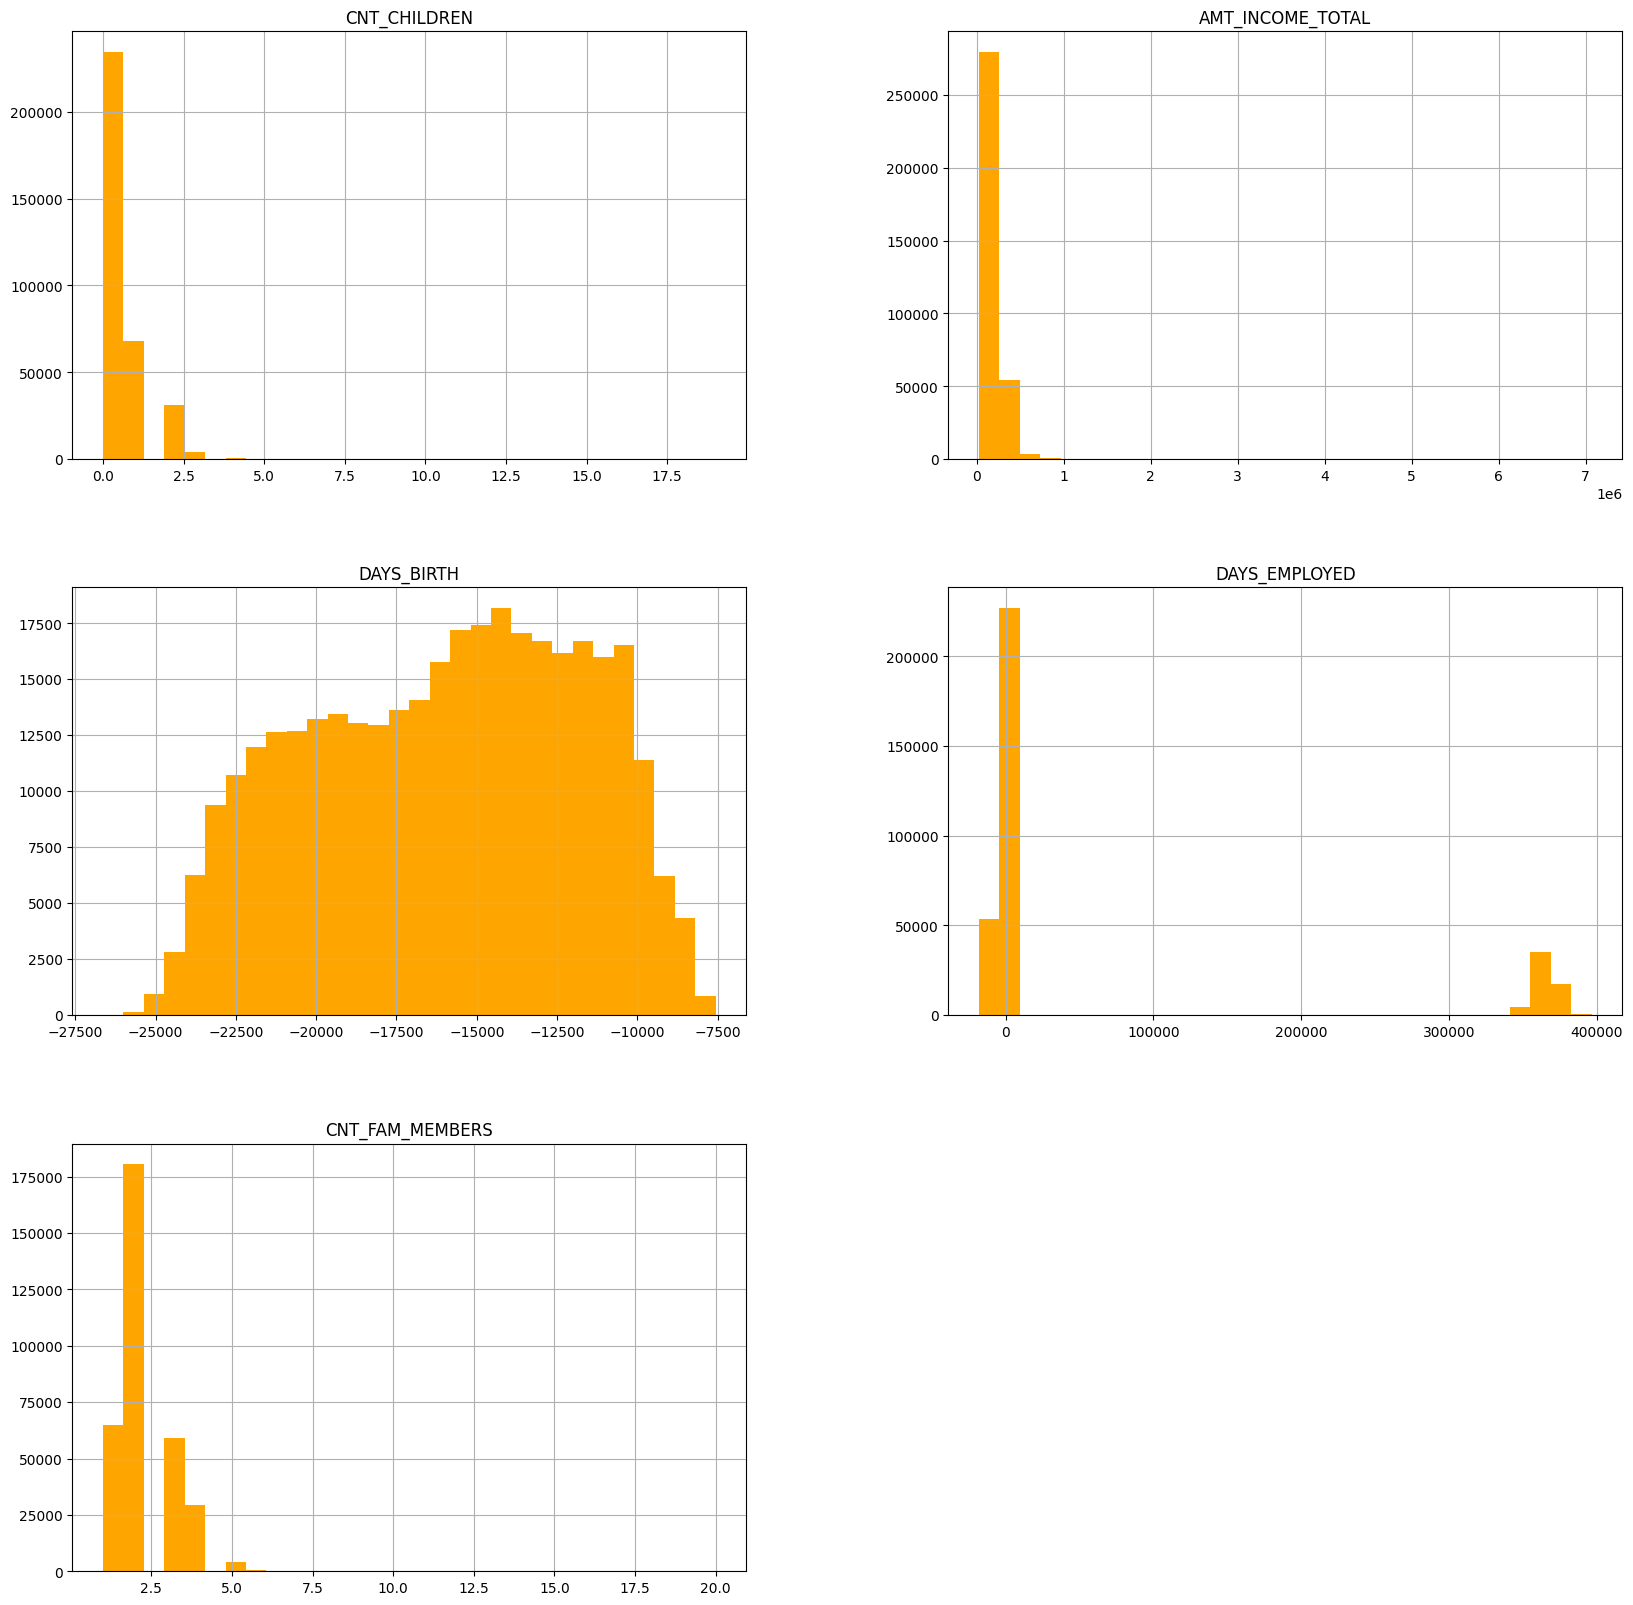

In [ ]:
df[["CNT_CHILDREN", "AMT_INCOME_TOTAL", "DAYS_BIRTH", "DAYS_EMPLOYED", "CNT_FAM_MEMBERS"]].hist(figsize=(20,20),
                                                                                                bins=30,
                                                                                                color= "orange")

#### Individuazione Outlier:

Trattandosi di **distribuzioni asimmetriche**, utilizziamo il **metodo dell'IQR (Interquartile Range)** per individuare gli outlier in modo più appropriato.

Esaminiamo immediatamente la variabile **DAYS_EMPLOYED**, che presenta una distribuzione particolare. Dal grafico si nota che la distribuzione ha due gruppi ben distinti:

- La maggior parte dei valori è concentrata vicino allo zero (con una coda verso sinistra).
- Un secondo gruppo con valori estremamente alti (~400.000 giorni, cioè oltre 1000 anni), che appare separato dal resto della distribuzione.

In [ ]:
df["DAYS_EMPLOYED"].sort_values(ascending=False).head(10)  # Controlliamo i valori più alti

200220    396498.0
202021    394139.0
292767    393302.0
259651    391827.0
305271    391202.0
167644    391122.0
186771    391010.0
288883    390822.0
139536    390626.0
98112     390395.0
Name: DAYS_EMPLOYED, dtype: float64

Verifichiamo se i valori estremamente alti appartengono solo a una classe di lavoratori. </br>
Considerando che l'età minima per iniziare a lavorare è generalmente 16 anni (in alcuni paesi anche inferiore, ma raramente), e che l'età media di pensionamento è attorno ai 70 anni, possiamo stimare che il massimo numero plausibile di anni di impiego sia circa 54 anni </br>(70-16=54).

Tuttavia, per evitare di adottare un criterio troppo rigido e considerare eventuali casi eccezionali (ad esempio, persone che lavorano oltre i 70 anni), definiamo come valore di soglia quelli superiori a 70 anni di impiego.


In [ ]:
df[df["DAYS_EMPLOYED"] > (70 * 365)]["NAME_INCOME_TYPE"].value_counts()


NAME_INCOME_TYPE
Pensioner    57841
Name: count, dtype: int64

Dall'analisi dell'output, emerge chiaramente che tutti i valori di `DAYS_EMPLOYED` superiori a 70 anni appartengono alla categoria **"Pensioner"** (57.841 casi). Questo suggerisce che tali valori non siano errori nei dati, ma piuttosto una codifica artificiale utilizzata per identificare i pensionati.  

Per preservare questa informazione senza introdurre distorsioni nel modello, creiamo una nuova variabile binaria, **`IS_PENSIONER`**, che indica se un individuo è pensionato. Successivamente, sostituiamo i valori anomali di `DAYS_EMPLOYED` prima con **NaN**, per segnalare la mancanza di un dato effettivo, e poi con **0**, in modo da garantire una gestione coerente e compatibile con l’algoritmo di machine learning.

In [ ]:
# Creating a new variable to identify pensioners (individuals whose `DAYS_EMPLOYED` exceeds the equivalent of seventy years).
df["IS_PENSIONER"] = (df["DAYS_EMPLOYED"] > (70 * 365)).astype(int)

In [ ]:
# Selecting rows where IS_PENSIONER is 1 and setting DAYS_EMPLOYED to NaN
df.loc[df["IS_PENSIONER"] == 1, "DAYS_EMPLOYED"] = np.nan

In [ ]:
# Replacing  Nan values with 1
df["DAYS_EMPLOYED"]=df["DAYS_EMPLOYED"].fillna(0)

In [ ]:
df.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0         424380.57               Working               Higher education   
1         421593.52               Working               Higher education   
2         110958.51               Working  Secondary / secondary special   
3         267497.96  Commercial associate  Secondary / secondary special   
4         263419.09  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment    -11778.0        -4438.0   
1        Civil marriage   Rented apartment    -11777.0        -4459.0   
2               Married  House / apartment    -21471.0        -1144.0   
3  Single / not married  House / apartment    -18489.0        -3122.0   
4  Single / not married  House / apartment    -19093.0        -3070.0   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0         1.0              1.0         0.0         0.0             NaN   
1         1.0              1.0         0.0         0.0             NaN   
2         1.0              0.0         0.0         0.0  Security staff   
3         1.0              0.0         1.0         1.0     Sales staff   
4         1.0              0.0         1.0         1.0     Sales staff   

   CNT_FAM_MEMBERS  TARGET  IS_PENSIONER  
0              2.0       0             0  
1              2.0       0             0  
2              2.0       0             0  
3              1.0       1             0  
4              1.0       1             0

Passiamo ora al calcolo degli outlier per tutte le variabili numeriche utilizzando il metodo **IQR (Interquartile Range)**.

In [ ]:
# Select only numerical columns before calculating quantiles
numerical_df = df[["CNT_CHILDREN", "AMT_INCOME_TOTAL", "DAYS_BIRTH", "DAYS_EMPLOYED", "CNT_FAM_MEMBERS"]]
Q1 = numerical_df.quantile(0.25)
Q3 = numerical_df.quantile(0.75)
IQR = Q3 - Q1

# Detect outliers only in numerical columns
outlier = ((numerical_df < (Q1 - 1.5 * IQR)) | (numerical_df > (Q3 + 1.5 * IQR)))

outlier.sum()

CNT_CHILDREN         4757
AMT_INCOME_TOTAL    14027
DAYS_BIRTH              0
DAYS_EMPLOYED       16924
CNT_FAM_MEMBERS      4440
dtype: int64

In [ ]:
# Percentage of outliers per column
(outlier.sum() / len(outlier)) * 100

CNT_CHILDREN        1.405621
AMT_INCOME_TOTAL    4.144764
DAYS_BIRTH          0.000000
DAYS_EMPLOYED       5.000783
CNT_FAM_MEMBERS     1.311952
dtype: float64

Osserviamo che la percentuale di outlier per ciascuna variabile numerica è relativamente bassa, il che indica che la presenza di valori anomali non è particolarmente significativa nel dataset.

Visualizziamo gli outlier graficamente con i boxplot per avere una visione piu chiara.

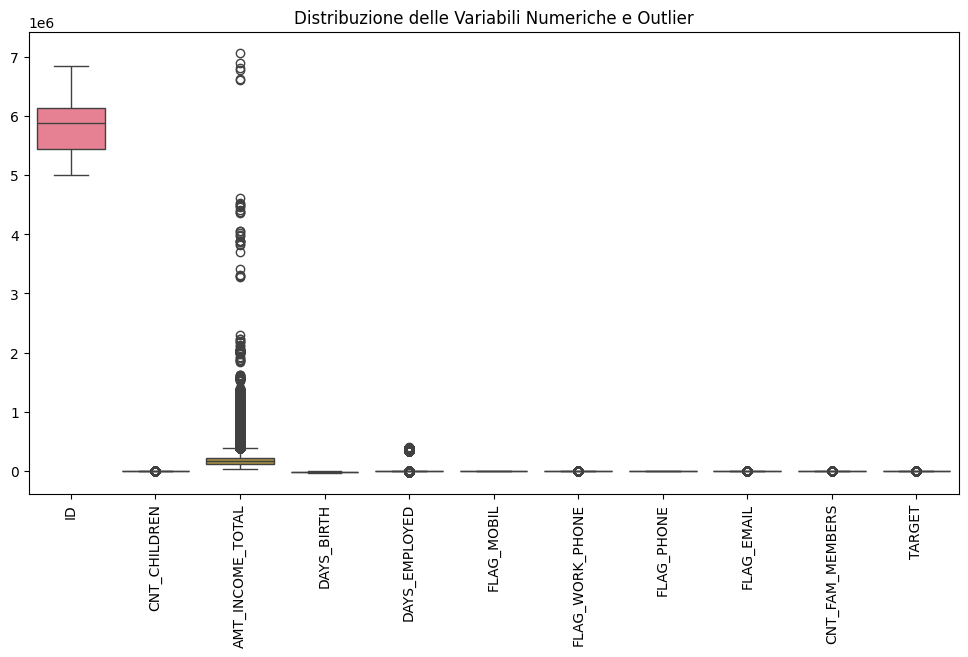

In [ ]:
numeric_features = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_features])
plt.xticks(rotation=90)
plt.title("Distribuzione delle Variabili Numeriche e Outlier")
plt.show()


Dalla rappresentazione grafica si osservano valori particolarmente elevati per la variabile **AMT_INCOME_TOTAL**, che rappresenta il reddito totale. Trattandosi di una variabile che può assumere valori molto alti in modo naturale, si ritiene opportuno mantenerla invariata senza applicare trasformazioni o rimozioni.

In [ ]:
df.describe()

ID   CNT_CHILDREN  AMT_INCOME_TOTAL     DAYS_BIRTH  \
count  3.384270e+05  338427.000000      3.384270e+05  338426.000000   
mean   5.821200e+06       0.428934      1.876685e+05  -15998.212897   
std    4.517704e+05       0.727990      1.107863e+05    4193.088539   
min    5.008804e+06       0.000000      2.554898e+04  -26636.000000   
25%    5.439602e+06       0.000000      1.212299e+05  -19467.000000   
50%    5.878907e+06       0.000000      1.628553e+05  -15623.000000   
75%    6.140206e+06       1.000000      2.252082e+05  -12516.250000   
max    6.841875e+06      19.000000      7.071016e+06   -7566.000000   

       DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE     FLAG_PHONE  \
count  338426.000000    338426.0    338426.000000  338426.000000   
mean    60234.533869         1.0         0.211379       0.293302   
std    138522.923248         0.0         0.408287       0.455276   
min    -17973.000000         1.0         0.000000       0.000000   
25%     -3116.000000         1.0         0.000000       0.000000   
50%     -1483.000000         1.0         0.000000       0.000000   
75%      -378.000000         1.0         0.000000       1.000000   
max    396498.000000         1.0         1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS         TARGET  
count  338426.000000    338426.000000  338427.000000  
mean        0.105181         2.197228       0.087824  
std         0.306787         0.899570       0.283039  
min         0.000000         1.000000       0.000000  
25%         0.000000         2.000000       0.000000  
50%         0.000000         2.000000       0.000000  
75%         0.000000         3.000000       0.000000  
max         1.000000        20.000000       1.000000

#### Distribuzione della variabile target (TARGET)

In [ ]:
df["TARGET"].value_counts()

TARGET
0    308705
1     29722
Name: count, dtype: int64

La variabile **TARGET** presenta un forte sbilanciamento, con la classe negativa significativamente più numerosa rispetto a quella positiva. Questo potrebbe influenzare le prestazioni del modello, quindi affronteremo il problema dello sbilanciamento nelle fasi successive.

## **Data Preprocessing**
Eseguo l'encoding delle variabili binarie sull'intero dataset, poiché, avendo solo due categorie, questa operazione non introduce il rischio di data leakage.

In [ ]:
df["FLAG_OWN_CAR"].unique()

array(['Y', 'N'], dtype=object)

In [ ]:
df["CODE_GENDER"].unique()

array(['M', 'F'], dtype=object)

In [ ]:
df["FLAG_OWN_REALTY"].unique()

array(['Y', 'N'], dtype=object)

In [ ]:
map= {"M":0, "F":1}
df["CODE_GENDER"]= df["CODE_GENDER"].map(map)

In [ ]:
map= {"N":0, "Y":1}
df["FLAG_OWN_CAR"]= df["FLAG_OWN_CAR"].map(map)

In [ ]:
map= {"N":0, "Y":1}
df["FLAG_OWN_REALTY"]= df["FLAG_OWN_REALTY"].map(map)

In [ ]:
for col in ['NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE']:
    print(f"{col}: {df[col].nunique()} categorie")


NAME_INCOME_TYPE: 5 categorie
OCCUPATION_TYPE: 18 categorie
NAME_FAMILY_STATUS: 5 categorie
NAME_EDUCATION_TYPE: 6 categorie
NAME_HOUSING_TYPE: 6 categorie


- Poiché abbiamo verificato che le variabili **NAME_INCOME_TYPE, NAME_FAMILY_STATUS, NAME_EDUCATION_TYPE** e **NAME_HOUSING_TYPE** contengono un numero limitato di categorie, utilizziamo il metodo **One-Hot Encoding**. Questo metodo crea una colonna per ogni categoria, assegnando il valore **0 o 1** in base all’appartenenza di ciascun dato a una specifica categoria. </br>
Per applicare il One-Hot Encoding, utilizziamo il metodo automatico `pd.get_dummies()`.


- Per la variabile **OCCUPATION_TYPE**, che presenta un numero elevato di categorie, optiamo invece per il **Frequency Encoding**. Questo approccio consente di evitare la creazione di un numero eccessivo di colonne, sostituendo ogni categoria con la sua **frequenza relativa** nel dataset.


Prima di applicare l'encoding alle **feature non binarie**, suddividiamo il dataset in **train** e **test** per evitare il **data leakage**. Successivamente, effettuiamo il **data cleaning** per correggere anomalie e migliorare la qualità dei dati. Solo dopo queste operazioni procediamo con l'encoding delle variabili.

In [ ]:
df["NAME_EDUCATION_TYPE"].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree',
       'Secondary / se'], dtype=object)

In [ ]:
df["NAME_EDUCATION_TYPE"].value_counts()


NAME_EDUCATION_TYPE
Secondary / secondary special    232568
Higher education                  91062
Incomplete higher                 11387
Lower secondary                    3177
Academic degree                     232
Secondary / se                        1
Name: count, dtype: int64

Poiché sembra esserci un errore di battitura nella classe **"Secondary / se"** relativa alla variabile **NAME_EDUCATION_TYPE**, procedo con l'unificazione delle due categorie, sostituendo **"Secondary / se"** con **"Secondary / secondary special"** per garantire coerenza nei dati.

In [ ]:
df["NAME_EDUCATION_TYPE"] = df["NAME_EDUCATION_TYPE"].replace(
    {"Secondary / se": "Secondary / secondary special"}
)


In [ ]:
df["NAME_EDUCATION_TYPE"].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    232569
Higher education                  91062
Incomplete higher                 11387
Lower secondary                    3177
Academic degree                     232
Name: count, dtype: int64

### **Divisione Dataset in Train e Test**

In [ ]:
X= df.drop("TARGET", axis=1)
y= df["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### **Data Cleaning**

#### Identificazione e Gestione Duplicati

In [ ]:
X_train.duplicated().sum()

np.int64(0)

#### Gestione Missing Values
In precedenza, abbiamo analizzato la presenza di valori mancanti nel dataset, riscontrando che la variabile **OCCUPATION_TYPE** presenta circa il 30% di valori nulli. Poiché si tratta di una variabile categorica e la percentuale di dati mancanti non è sufficientemente alta da giustificarne l'eliminazione, optiamo per **l'imputazione con la moda** utilizzando il metodo **SimpleImputer**.  

Successivamente, imputiamo anche le variabili che presentano un **numero minimo di valori mancanti**, garantendo così la completezza del dataset prima delle fasi successive dell'analisi.

In [ ]:
imp_c= SimpleImputer(strategy='most_frequent')
X_train[["OCCUPATION_TYPE","NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]]= imp_c.fit_transform(X_train[["OCCUPATION_TYPE","NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]])
X_test[["OCCUPATION_TYPE","NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]]= imp_c.transform(X_test[["OCCUPATION_TYPE","NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]])

In [ ]:
imp_n = SimpleImputer(strategy='median')
X_train[["DAYS_BIRTH","DAYS_EMPLOYED", "FLAG_MOBIL","FLAG_WORK_PHONE","FLAG_PHONE", "FLAG_EMAIL", "CNT_FAM_MEMBERS"]]= imp_n.fit_transform(X_train[["DAYS_BIRTH","DAYS_EMPLOYED", "FLAG_MOBIL","FLAG_WORK_PHONE","FLAG_PHONE", "FLAG_EMAIL", "CNT_FAM_MEMBERS"]])
X_test[["DAYS_BIRTH","DAYS_EMPLOYED", "FLAG_MOBIL","FLAG_WORK_PHONE","FLAG_PHONE", "FLAG_EMAIL", "CNT_FAM_MEMBERS"]]= imp_n.transform(X_test[["DAYS_BIRTH","DAYS_EMPLOYED", "FLAG_MOBIL","FLAG_WORK_PHONE","FLAG_PHONE", "FLAG_EMAIL", "CNT_FAM_MEMBERS"]])

In [ ]:
X_train.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
IS_PENSIONER           0
dtype: int64

In [ ]:
X_test.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
IS_PENSIONER           0
dtype: int64

### **Feature Engineering**
#### Encoding Variabili Non Binarie

In [ ]:
# Defining categorical columns
categorical_cols = ["NAME_INCOME_TYPE", "NAME_FAMILY_STATUS", "NAME_EDUCATION_TYPE", "NAME_HOUSING_TYPE"]

# Creating OneHotEncoder object
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Fitting the encoder on the training set and applying the same transformation to the test set
X_train_encoded = ohe.fit_transform(X_train[categorical_cols])
X_test_encoded = ohe.transform(X_test[categorical_cols])

# Converting the transformed data into DataFrame with proper column names
encoded_columns = ohe.get_feature_names_out(categorical_cols)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

# Removing the original categorical columns
X_train.drop(columns=categorical_cols, inplace=True)
X_test.drop(columns=categorical_cols, inplace=True)

# Concatenating the encoded features with the original dataset
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

# Verifying the result
print(X_train.head())
print(X_test.head())

             ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
207024  5927621            0             1                0             0   
89243   5354131            1             0                1             1   
213141  5944564            0             0                0             0   
186816  5861340            1             1                1             0   
224922  5978545            1             1                0             0   

        AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
207024         224531.87    -18243.0        -6273.0         1.0   
89243           88955.80    -12386.0        -2358.0         1.0   
213141         156389.03    -11969.0        -1571.0         1.0   
186816          90052.43    -16309.0        -4545.0         1.0   
224922         197862.27    -21445.0            0.0         1.0   

        FLAG_WORK_PHONE  ...  NAME_EDUCATION_TYPE_Higher education  \
207024              1.0  ...                                   1

Verifichiamo che l'encoding sia stato eseguito correttamente

In [ ]:
print("Dopo encoding, NaN in X_train:\n", X_train.isnull().sum().sum())
print("Dopo encoding, NaN in X_test:\n", X_test.isnull().sum().sum())

Dopo encoding, NaN in X_train:
 0
Dopo encoding, NaN in X_test:
 0


In [ ]:
print(X_train.shape, X_test.shape)


(270741, 36) (67686, 36)


In [ ]:
# Calculate relative frequency of each category in OCCUPATION_TYPE
freq_map = X_train['OCCUPATION_TYPE'].value_counts(normalize=True)

# Substitute each category with its frequency
X_train['OCCUPATION_TYPE'] = X_train['OCCUPATION_TYPE'].map(freq_map)
X_test['OCCUPATION_TYPE'] = X_test['OCCUPATION_TYPE'].map(freq_map)


In [ ]:
X_test["OCCUPATION_TYPE"].head()

300784    0.093440
247668    0.483056
88685     0.483056
300092    0.483056
305260    0.039939
Name: OCCUPATION_TYPE, dtype: float64

### Creazione Nuove Features

Dalla variabile **DAYS_BIRTH**, che rappresenta il numero di giorni trascorsi dalla nascita, possiamo calcolare l'**età in anni** delle persone.  

Allo stesso modo, dalla variabile **DAYS_EMPLOYED**, che indica il numero di giorni trascorsi dalla data di assunzione (valori positivi indicano il numero di giorni di disoccupazione), possiamo ricavare gli **anni di disoccupazione**.

In [ ]:
# Creating new features only on the training set
X_train["AGE"] = X_train["DAYS_BIRTH"].apply(lambda x: abs(x // 365))
X_train["YEARS_EMPLOYED"] = X_train["DAYS_EMPLOYED"].apply(lambda x: abs(x // 365) if x < 0 else x // 365)

# Applying the same transformations to the test set
X_test["AGE"] = X_test["DAYS_BIRTH"].apply(lambda x: abs(x // 365))
X_test["YEARS_EMPLOYED"] = X_test["DAYS_EMPLOYED"].apply(lambda x: abs(x // 365) if x < 0 else x // 365)

# Dropping the original columns
X_train.drop("DAYS_BIRTH", axis=1, inplace=True)
X_train.drop("DAYS_EMPLOYED", axis=1, inplace=True)
X_test.drop("DAYS_BIRTH", axis=1, inplace=True)
X_test.drop("DAYS_EMPLOYED", axis=1, inplace=True)


In [ ]:
X_train["AGE"].value_counts()

AGE
40.0    8323
39.0    8275
41.0    8113
43.0    7908
38.0    7899
42.0    7855
37.0    7784
44.0    7695
29.0    7654
36.0    7637
32.0    7633
33.0    7609
30.0    7497
35.0    7489
34.0    7332
31.0    7231
45.0    7058
28.0    6783
46.0    6557
47.0    6359
48.0    6317
54.0    6269
49.0    6151
53.0    6144
55.0    6135
51.0    6030
52.0    6026
56.0    5922
58.0    5910
50.0    5906
59.0    5771
57.0    5724
60.0    5625
61.0    5315
62.0    4973
63.0    4719
27.0    4393
64.0    4316
65.0    3479
26.0    3112
66.0    2553
25.0    2462
24.0    2130
67.0    1562
23.0    1329
68.0     852
69.0     471
22.0     235
70.0     153
71.0      50
72.0       9
21.0       5
73.0       2
Name: count, dtype: int64

In [ ]:
X_train["YEARS_EMPLOYED"].value_counts()

YEARS_EMPLOYED
0.0     46331
2.0     23828
3.0     22926
4.0     20569
1.0     20548
5.0     18847
6.0     15250
7.0     14821
8.0     13322
9.0     11954
10.0     9475
11.0     7579
12.0     5819
13.0     5414
14.0     4695
15.0     4676
16.0     3301
17.0     2384
18.0     2051
20.0     1973
19.0     1844
22.0     1638
21.0     1608
23.0     1350
24.0     1049
25.0      986
26.0      884
28.0      790
27.0      765
29.0      671
30.0      558
31.0      452
32.0      443
34.0      333
33.0      326
35.0      318
36.0      229
37.0      162
38.0      139
40.0      106
39.0       99
41.0       68
42.0       60
43.0       36
44.0       28
45.0       22
46.0        7
47.0        4
48.0        2
49.0        1
Name: count, dtype: int64

In [ ]:
X_train.sort_values(by="YEARS_EMPLOYED", ascending=False).head(10)

ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
102188  5424512            1             1                1             0   
102185  5424507            1             1                1             0   
102190  5585289            1             1                1             0   
102187  5424511            1             1                1             0   
278670  6110024            0             0                1             0   
278668  6110022            0             0                1             0   
50797   5155962            0             0                1             0   
278667  6110021            0             0                1             0   
162490  5761728            1             0                0             0   
58852   5183003            1             0                1             0   

        AMT_INCOME_TOTAL  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
102188         130387.07         1.0              0.0         1.0         0.0   
102185         132426.86         1.0              0.0         1.0         0.0   
102190         135213.12         1.0              0.0         1.0         0.0   
102187         137642.87         1.0              0.0         1.0         0.0   
278670         290768.98         1.0              1.0         1.0         0.0   
278668         297202.66         1.0              1.0         1.0         0.0   
50797          180688.44         1.0              0.0         0.0         0.0   
278667         287230.12         1.0              1.0         1.0         0.0   
162490         101885.52         1.0              1.0         1.0         0.0   
58852          405249.77         1.0              0.0         0.0         0.0   

        ...  NAME_EDUCATION_TYPE_Lower secondary  \
102188  ...                                  0.0   
102185  ...                                  0.0   
102190  ...                                  0.0   
102187  ...                                  0.0   
278670  ...                                  0.0   
278668  ...                                  0.0   
50797   ...                                  0.0   
278667  ...                                  0.0   
162490  ...                                  0.0   
58852   ...                                  0.0   

        NAME_EDUCATION_TYPE_Secondary / secondary special  \
102188                                                1.0   
102185                                                1.0   
102190                                                1.0   
102187                                                1.0   
278670                                                1.0   
278668                                                1.0   
50797                                                 1.0   
278667                                                1.0   
162490                                                0.0   
58852                                                 0.0   

        NAME_HOUSING_TYPE_Co-op apartment  \
102188                                0.0   
102185                                0.0   
102190                                0.0   
102187                                0.0   
278670                                0.0   
278668                                0.0   
50797                                 0.0   
278667                                0.0   
162490                                0.0   
58852                                 0.0   

        NAME_HOUSING_TYPE_House / apartment  \
102188                                  1.0   
102185                                  1.0   
102190                                  1.0   
102187                                  1.0   
278670                                  1.0   
278668                                  1.0   
50797                                   1.0   
278667                                  1.0   
162490                                  1.0   
58852                                   1.0   

        NAME_H

#### Selezione delle Features più Rilevanti

Analizziamo le relazioni tra le variabili del dataset utilizzando una **heatmap di correlazione**, che ci permette di individuare eventuali dipendenze tra le feature e identificare possibili ridondanze nei dati.

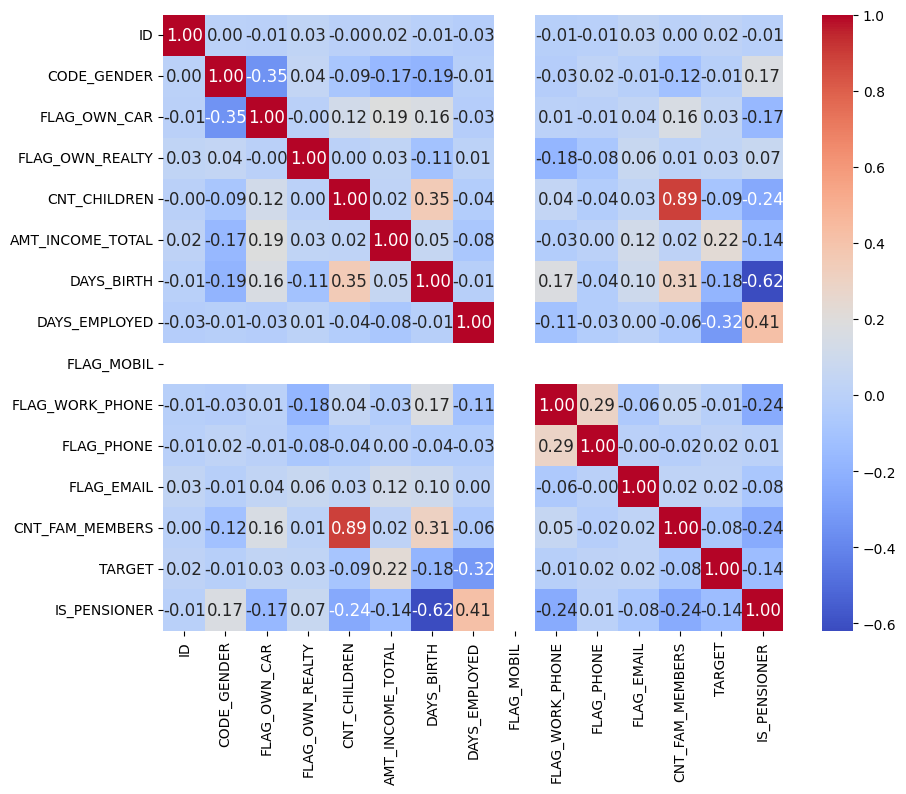

In [ ]:
num_col= df.select_dtypes(include=["int64", "float64"]).columns
correlation_matrix= df[num_col].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            annot_kws ={"size":12})
plt.show()

Le variabili più correlate alla variabile TARGET risultano essere:
- DAYS_EMPLOYED (-0.32), che mostra una lieve correlazione negativa. Questo significa che minore è il numero di giorni da cui un individuo è impiegato, maggiore è la probabilità che venga considerato affidabile dal modello. </br>
Questo potrebbe indicare che i clienti che sono occupati da meno tempo (o da poco reimpiegati) non vengono necessariamente considerati meno affidabili, anzi, potrebbero avere una maggiore probabilità di rispettare i pagamenti rispetto a chi ha un'anzianità lavorativa molto lunga (che potrebbe coincidere con un'età più avanzata e minore stabilità economica).

- AMT_INCOME_TOTAL (+0.22) indica che più alto è il reddito, maggiore è la probabilità di essere affidabile.
Appare logico infatti che chi ha un reddito più alto ha più probabilità di poter rimborsare i pagamenti in modo regolare.

- DAYS_BIRTH (-0.18) mostra che più giovane è il cliente, maggiore è la probabilità di essere affidabile.
Questo potrebbe indicare che i clienti più giovani potrebbero essere nella fase della carriera in cui hanno un reddito crescente e meno spese mediche o familiari.

## **Addestramento Modello**
Passiamo ora alla fase di addestramento del modello. Poiché si tratta di un problema di classificazione binaria, in cui dobbiamo prevedere la variabile TARGET (che assume valore 1 se il cliente ha un'elevata affidabilità creditizia e 0 altrimenti), utilizziamo come modello baseline la Regressione Logistica.

Questo approccio ci permetterà di stabilire un primo riferimento sulle prestazioni del modello, che potrà essere successivamente migliorato con tecniche più avanzate.

In [ ]:

# Using Stratified K-Fold Cross Validation for imbalanced datasets
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Performing Cross Validation (before training the final model)
lr = LogisticRegression(max_iter=500)
scores = cross_val_score(lr, X_train, y_train, cv=skf, scoring="accuracy")

# Printing the average accuracy from Cross Validation
print(f"Accuracy (Cross Validation): {scores.mean():.4f}")

Accuracy (Cross Validation): 0.9110


In [ ]:
# Final training of the model on the entire training set
lr.fit(X_train, y_train)


LogisticRegression(max_iter=500)

In [ ]:
# Predicting on the test data
y_pred = lr.predict(X_test)

In [ ]:
# Final evaluation using the Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     61783
           1       0.50      0.18      0.27      5903

    accuracy                           0.91     67686
   macro avg       0.71      0.58      0.61     67686
weighted avg       0.89      0.91      0.89     67686



Le performance del modello sono ottime per la classe negativa, ma risultano molto scarse per la classe positiva. Questo indica un forte sbilanciamento nella classificazione. Se il modello catturasse meglio le relazioni tra le variabili e la variabile target (come avverrebbe in un modello più robusto o con una migliore rappresentazione dei dati), ci aspetteremmo prestazioni più bilanciate tra le due classi rispetto a quelle osservate.

- Classe 0 (negativa)

  - Precisione: 0.93 → Il modello identifica bene i negativi (bassa probabilità di falsi positivi).
  - Recall: 0.98 → Riesce quasi sempre a trovare i negativi (pochi falsi negativi).
  - F1-score: 0.95 → Ottima bilanciatura tra precision e recall.
  
  
- Classe 1 (positiva)

  - Precisione: 0.50 → Il modello è incerto nel classificare i positivi (alta probabilità di falsi positivi).
  - Recall: 0.18 → Riconosce pochi casi positivi (molti falsi negativi).
  - F1-score: 0.27 → Complessivamente, per la classe 1 il modello è debole.

Prima di procedere con l'addestramento di un modello più avanzato, affrontiamo lo sbilanciamento della classe utilizzando tecniche di **resampling**. Poiché il dataset dispone di un numero sufficiente di osservazioni, optiamo per l'**undersampling**, riducendo il numero di esempi appartenenti alla classe maggioritaria per migliorare l'equilibrio tra le classi.

In [ ]:
# Initialize the undersampler to balance the dataset by reducing the majority class
undersampler = RandomUnderSampler(random_state=RANDOM_SEED)

# Apply undersampling to the training dataset
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Train the logistic regression model on the resampled dataset
lr.fit(X_train_resampled, y_train_resampled)


LogisticRegression(max_iter=500)

In [ ]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

# Extract only the probability of class 1 (the positive class we are interested in)
y_pred_prob = lr.predict_proba(X_test)[:, 1]
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob))


              precision    recall  f1-score   support

           0       0.98      0.81      0.88     61783
           1       0.28      0.80      0.42      5903

    accuracy                           0.81     67686
   macro avg       0.63      0.80      0.65     67686
weighted avg       0.92      0.81      0.84     67686

AUC-ROC Score: 0.88262479195894


Le prestazioni del modello dopo l'applicazione dell'undersampling sembrano essere notevolmente migliorate, soprattutto in termini di **recall**. Si osservano anche miglioramenti significativi nel **F1-score** e un peggioramento nella **precision**. I valori ottenuti restano ancora insufficienti per considerare il modello un buon predittore.

Per completezza, proviamo ad adottare l'oversampling, in modo da valutare entrambe le strategie e prendere una decisione più consapevole.

In [ ]:
# Initialize the RandomOverSampler to balance the dataset by oversampling the minority class
oversampler = RandomOverSampler(random_state=RANDOM_SEED)

# Apply oversampling to the training set
X_train_resamp, y_train_resamp = oversampler.fit_resample(X_train, y_train)

# Train the logistic regression model on the resampled dataset
lr.fit(X_train_resamp, y_train_resamp)


LogisticRegression(max_iter=500)

In [ ]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))  # Print classification report with precision, recall, and F1-score

# Obtain the probability of class 1 (the positive class we are interested in)
y_pred_prob = lr.predict_proba(X_test)[:, 1]

# Compute and print the AUC-ROC score, which evaluates the model's ability to distinguish between classes
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     61783
           1       0.30      0.83      0.44      5903

    accuracy                           0.82     67686
   macro avg       0.64      0.82      0.66     67686
weighted avg       0.92      0.82      0.85     67686

AUC-ROC Score: 0.8949192968260771


L'applicazione dell'oversampling ha portato a un leggero miglioramento delle performance. Tuttavia, i risultati ottenuti non sono ancora sufficientemente soddisfacenti per considerare il modello efficace.

Passiamo ora all’utilizzo di un modello ampiamente impiegato nell’analisi dell’affidabilità creditizia: i Decision Tree. Si tratta di un algoritmo di machine learning supervisionato, spesso utilizzato per la classificazione. Per garantire una valutazione più bilanciata, adotteremo strategie mirate per gestire lo sbilanciamento delle classi.

In [ ]:
dtc= DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=RANDOM_SEED)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [ ]:
y_pred=dtc.predict(X_test)

In [ ]:
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_prob = dtc.predict_proba(X_test)[:, 1] # Obtain the probability of class 1 (the class we are interested in)
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     61783
           1       0.68      0.94      0.79      5903

    accuracy                           0.96     67686
   macro avg       0.84      0.95      0.88     67686
weighted avg       0.97      0.96      0.96     67686

AUC-ROC Score: 0.9750081181354854


In [ ]:
scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring="precision")
print("Cross-Val F1:", scores.mean())

Cross-Val F1: 0.6791603637905032


In [ ]:
scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring="f1")
print("Cross-Val F1:", scores.mean())


Cross-Val F1: 0.785955625061156


Le prestazioni del modello sono **eccellenti** nella previsione della classe negativa. Tuttavia, per la classe positiva, l'unico valore significativamente più basso è la **precision**, che si attesta al **67%**.  

Ciò significa che **circa il 30% delle previsioni positive sono errate**, ovvero il modello classifica erroneamente alcuni clienti come **affidabili** quando in realtà non lo sono. Questo potrebbe essere un aspetto critico, soprattutto se l'obiettivo è ridurre al minimo il rischio di concedere credito a clienti inaffidabili.

Ottimizziamo i parametri del modello utilizzando **GridSearchCV** per identificare la combinazione ottimale di iperparametri. Successivamente, valutiamo se le prestazioni del modello migliorano rispetto alla configurazione precedente.

In [ ]:
param_grid = {
    "max_depth": [3, 5, 7, 10],  # Testing trees with different depths (shallower or deeper)
    "min_samples_split": [2, 5, 10],  # Minimum number of samples required to split a node
    "min_samples_leaf": [1, 2, 5]  # Minimum number of samples required in each leaf
}

# Performing grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_SEED), param_grid, cv=5, scoring="f1")

# Training the model with different combinations of hyperparameters
grid_search.fit(X_train, y_train)

# Displaying the best combination of hyperparameters found
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Applying best arameters to the model
dtc= DecisionTreeClassifier(criterion="gini", max_depth=3, min_samples_split= 2, min_samples_leaf=1, random_state=RANDOM_SEED)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [ ]:
y_predicted = dtc.predict(X_train)
print(classification_report(y_train, y_predicted))
y_pred_proba = dtc.predict_proba(X_train)[:, 1]
print("AUC-ROC Score:", roc_auc_score(y_train, y_pred_proba))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    246922
           1       0.67      0.96      0.79     23819

    accuracy                           0.96    270741
   macro avg       0.83      0.96      0.88    270741
weighted avg       0.97      0.96      0.96    270741

AUC-ROC Score: 0.9743753360402198


In [ ]:
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_prob = dtc.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_prob > 0.6).astype(int)  # Changes threshold from 0.5 to 0.6
print(classification_report(y_test, y_pred_adjusted))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     61783
           1       0.67      0.95      0.79      5903

    accuracy                           0.96     67686
   macro avg       0.84      0.96      0.88     67686
weighted avg       0.97      0.96      0.96     67686

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     61783
           1       0.67      0.95      0.79      5903

    accuracy                           0.96     67686
   macro avg       0.84      0.96      0.88     67686
weighted avg       0.97      0.96      0.96     67686

AUC-ROC Score: 0.9743228561664361
AUC-ROC Score: 0.9550130823661835


In [ ]:
scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring="precision")
print("Cross-Val Precision:", scores.mean())

Cross-Val Precision: 0.673633310546945


In [ ]:
scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring="f1")
print("Cross-Val F1:", scores.mean())

Cross-Val F1: 0.7901220508637634


In [ ]:
scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring="recall")
print("Cross-Val Recall:", scores.mean())

Cross-Val Recall: 0.9553716612433549


Il valore di **cross-validation** per **precision, recall e F1-score** conferma la **stabilità del modello**, indicando che **l'overfitting non sembra essere un problema critico**.  

Poiché, nonostante l'ottimizzazione dei parametri tramite **Grid Search** e la modifica della soglia di decisione, le metriche rimangono pressoché costanti, si può concludere che il **modello ha probabilmente raggiunto le sue massime prestazioni**.  

Ho scelto di **non utilizzare Random Forest** per mantenere un **elevato livello di interpretabilità**, un aspetto fondamentale in questo contesto. Infatti, nel caso in cui **la richiesta di carta di credito venga rifiutata**, il consulente deve essere in grado di **fornire al cliente una spiegazione chiara** sulla motivazione del rifiuto.  

Per garantire questa **trasparenza**, ho visualizzato e stampato a schermo l'**albero decisionale**, in modo da rendere comprensibili i criteri con cui il modello prende le decisioni.

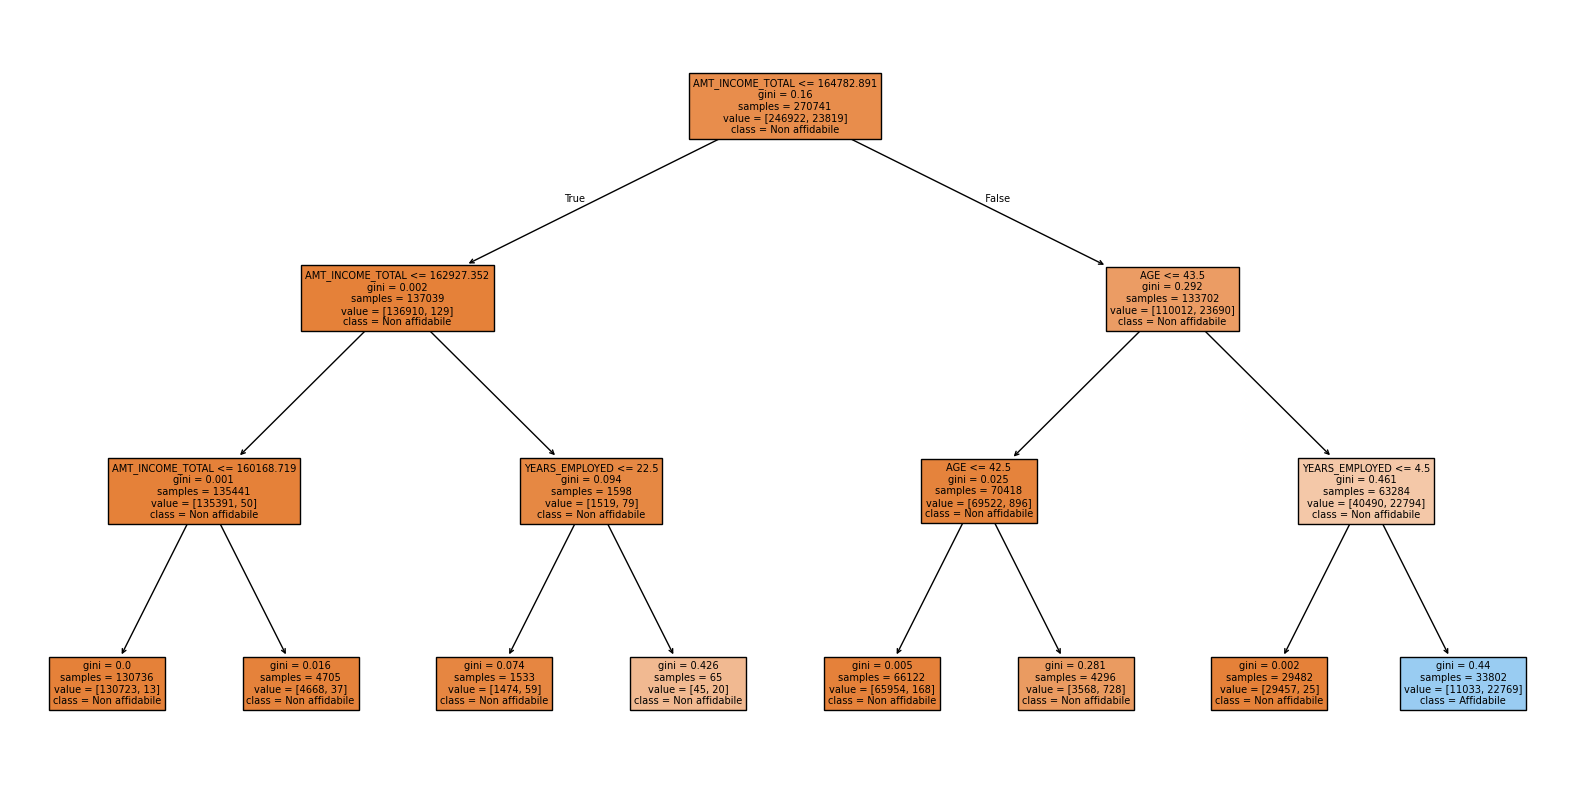

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(dtc, feature_names=X_train.columns, class_names=["Non affidabile", "Affidabile"], filled=True)
plt.show()


### **Analisi del Modello Decisionale**
Dall'albero decisionale mostrato in figura emergono alcuni aspetti chiave. Come evidenziato precedentemente dall’**heatmap di correlazione**, il modello basa le proprie decisioni principalmente su **tre variabili**, classificate per importanza nel seguente ordine:
1. **Reddito annuale totale**  
2. **Età**  
3. **Anni di impiego**  

</br>

#### *Esempio 1: Cliente con reddito di 120.000€, 7 anni di impiego e 45 anni*
Analizziamo il percorso decisionale del modello per un individuo con queste caratteristiche:

1. **Il reddito totale è minore o uguale a 164.782,9?** → **Sì** (ramo a sinistra)  
2. **Il reddito totale è minore o uguale a 160.168,7?** → **Sì** (ramo a sinistra)  
3. **Esito:** **Non affidabile**  


In questo caso, il modello **non considera neanche età e anni di impiego**, prendendo la decisione basandosi esclusivamente sul reddito.

</br>

#### *Esempio 2: Cliente con reddito di 200.000€, 4 anni di impiego e 32 anni*
Vediamo ora il percorso decisionale per un individuo con un reddito superiore:

1. **Il reddito totale è minore o uguale a 164.782,9?** → **No** (ramo a destra)  
2. **L'età è minore o uguale a 43,5 anni?** → **Sì** (ramo a sinistra)  
3. **Esito:** **Non affidabile**  
  
In questo caso, il reddito supera la soglia minima richiesta, ma il modello esclude l’individuo basandosi sull’età.

</br>

#### **Requisiti minimi per essere considerati affidabili**
Dall’analisi dell’albero decisionale, emergono i **criteri minimi** affinché un cliente venga classificato come **affidabile**:
- **Reddito annuale superiore a 164.782,9€**  
- **Età superiore a 43,5 anni**  
- **Anni di impiego superiori a 4,5**  

Se un cliente non soddisfa almeno uno di questi criteri, il modello lo classifica automaticamente come **non affidabile**, indipendentemente dagli altri fattori.  

